In [26]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [15]:
df = pd.read_csv('../data/brutos/resultado_pocos.csv', sep=';', encoding='latin-1')

In [22]:
def gerar_dados_sinteticos(df_original):
    np.random.seed(42)
    n = len(df_original)

    df_original['porosidade_pct'] = np.clip(np.random.normal(18, 4, n), 8, 28)
    df_original['espessura_zona_prod_m'] = np.random.uniform(5, 60, n)
    df_original['pressao_reservatorio_psi'] = np.random.lognormal(mean=8, sigma=0.6, size=n)
    df_original['pressao_reservatorio_psi'] = np.clip(df_original['pressao_reservatorio_psi'], 100, 5000)
    df_original['saturacao_oleo_pct'] = np.random.uniform(30, 85, n)

    litologias = ['Arenito', 'Folhelho', 'Calcário', 'Conglomerado']
    probs = [0.6, 0.25, 0.1, 0.05]
    df_original['litologia'] = np.random.choice(litologias, size=n, p=probs)

    df_original['produtividade_inicial_bpd'] = (
        0.8 * df_original['porosidade_pct'] +
        1.2 * df_original['espessura_zona_prod_m'] +
        0.015 * df_original['pressao_reservatorio_psi'] +
        np.random.normal(0, 20, n)
    )

    df_original['produtividade_inicial_bpd'] = df_original['produtividade_inicial_bpd'].clip(lower=50)
    return df_original

# 3. Aplica geração
df_sintetico = gerar_dados_sinteticos(df.copy())

# 4. Converte coordenadas para decimal
lat_dms = df['Latitude'].str.extract(r'(-?\d+):(\d+):([\d,]+)')
lon_dms = df['Longitude'].str.extract(r'(-?\d+):(\d+):([\d,]+)')

def dms_para_decimal(dms_tuple):
    grau, minuto, segundo = dms_tuple
    grau = int(grau)
    minuto = int(minuto)
    segundo = float(segundo.replace(',', '.'))
    return grau + minuto / 60 + segundo / 3600

df_sintetico['lat'] = lat_dms.apply(lambda x: dms_para_decimal(x), axis=1) * -1
df_sintetico['lon'] = lon_dms.apply(lambda x: dms_para_decimal(x), axis=1)

# 5. Mapa
mapa = folium.Map(location=[-15.5, -47.5], zoom_start=5)
cluster = MarkerCluster().add_to(mapa)

for _, row in df_sintetico.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        tooltip=f"{row['Nome Poço ANP']} - {row['litologia']}",
        popup=f"Bacia: {row['Bacia']}<br>Produtividade: {row['produtividade_inicial_bpd']:.1f} bpd"
    ).add_to(cluster)

mapa

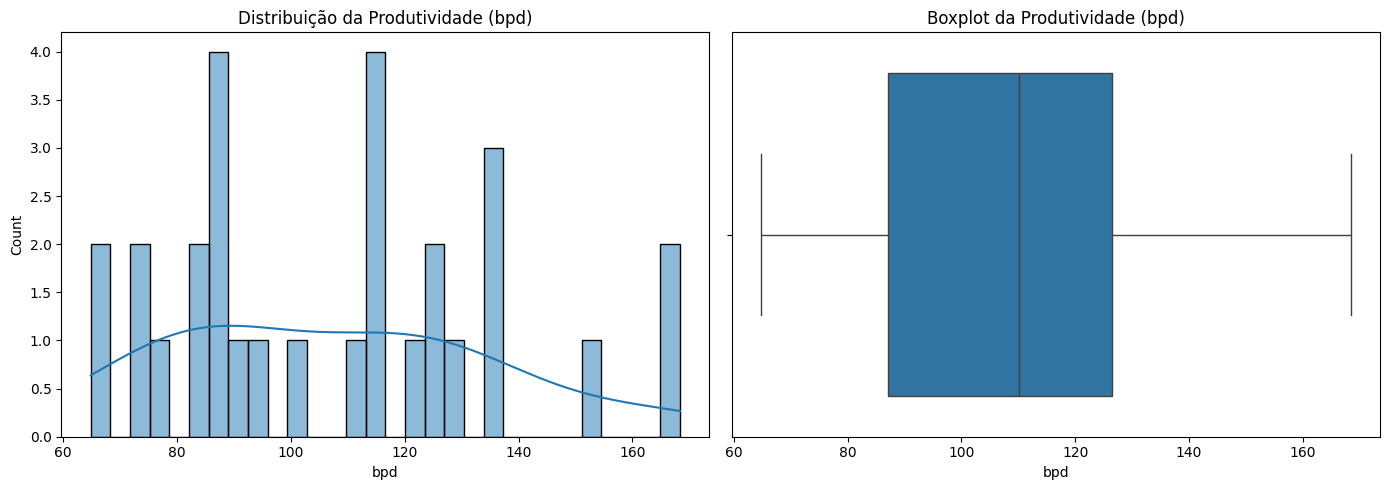

In [24]:
plt.figure(figsize=(14, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df_sintetico['produtividade_inicial_bpd'], bins=30, kde=True)
plt.title('Distribuição da Produtividade (bpd)')
plt.xlabel('bpd')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_sintetico['produtividade_inicial_bpd'])
plt.title('Boxplot da Produtividade (bpd)')
plt.xlabel('bpd')

plt.tight_layout()
plt.show()

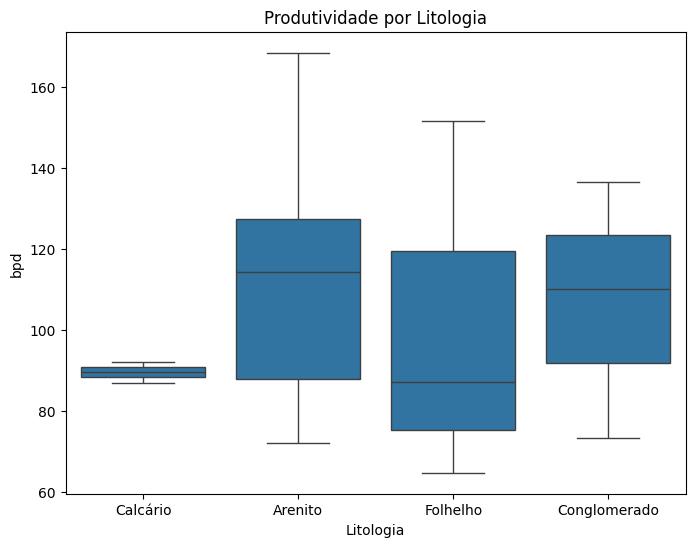

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='litologia', y='produtividade_inicial_bpd', data=df_sintetico)
plt.title('Produtividade por Litologia')
plt.xlabel('Litologia')
plt.ylabel('bpd')
plt.show()

In [27]:
fig = px.box(
    df_sintetico,
    x='litologia',
    y='produtividade_inicial_bpd',
    color='litologia',
    title='Distribuição da Produtividade por Litologia',
    points='all'
)

fig.show()

In [28]:
mapa = folium.Map(location=[-15.5, -47.5], zoom_start=5)

for _, row in df_sintetico.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5 + row['produtividade_inicial_bpd'] / 100,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=(
            f"<b>Poço:</b> {row['Nome Poço ANP']}<br>"
            f"<b>Bacia:</b> {row['Bacia']}<br>"
            f"<b>Litologia:</b> {row['litologia']}<br>"
            f"<b>Produtividade:</b> {row['produtividade_inicial_bpd']:.1f} bpd"
        )
    ).add_to(mapa)

mapa
